# Conditional variational autoencoder


Import all the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

## Data

Load MNIST dataset

In [2]:
def load_mnist():
  # load
  mnist_dataset = mnist.load_data()
  (trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
  (X_train, y_train) = trainset
  (X_test, y_test) = testset
  # preprocess
  X_train = X_train.astype('float32')
  X_train /= 255
  X_test = X_test.astype('float32')
  X_test /= 255
  # Flatten - VAE will be made as fully-connected network
  X_train_fl = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
  X_test_fl = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
  return X_train_fl, y_train, X_test_fl, y_test

In [3]:
X_train, y_train, X_test, y_test = load_mnist()

Show data

In [4]:
def show_images(X, n_images=4):
  fig = plt.figure()
  for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    X_plot = X[i].reshape((28,28))
    plt.imshow(X_plot, cmap='gray')
  plt.show()

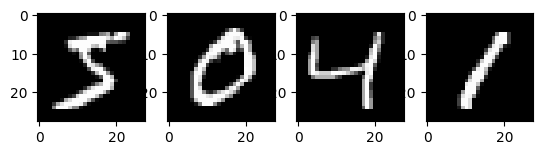

In [5]:
show_images(X_train, n_images=4)

TODO - Convert labels to one-hot

In [8]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)


## Model

Network parameters

In [9]:
input_size = 28*28
optimizer = 'adam'
batch_size=250
epochs=50

intermediate_dim = 512
latent_dim = 2

n_classes = y_train_one_hot.shape[1]

TODO - Build an encoder. Make sure that images and labels are concatenated before passing them to intermediate layer.

In [10]:
from tensorflow.keras.layers import Concatenate

# Define the encoder input
input_img = Input(shape=(784,), name='input_img')  # assuming each MNIST image is flattened to 784 features
label_input = Input(shape=(10,), name='label_input')  # assuming one-hot encoded label

# Concatenate the image input with the label input
concatenated_input = Concatenate()([input_img, label_input])


TODO - Write a function for sampling from Gaussian, and make a Lambda layer. 
You should merge sampled z with the label and instantiate an encoder model.

In [11]:
# Sampling function using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # Sample epsilon from a standard normal distribution
    epsilon = K.random_normal(shape=(batch, dim))
    # Return sampled z = mean + std * epsilon
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder layers
latent_dim = 2  # Dimension of the latent space
x = Dense(512, activation='relu')(concatenated_input)
x = Dense(256, activation='relu')(x)

# Latent variables: mean and log variance
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling layer
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Merge sampled z with label
z_label_merged = Concatenate()([z, label_input])

# Instantiate encoder model
encoder = Model([input_img, label_input], [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 784)]                0         []                            
                                                                                                  
 label_input (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 794)                  0         ['input_img[0][0]',           
                                                                     'label_input[0][0]']         
                                                                                                  
 dense (Dense)               (None, 512)                  407040    ['concatenate[0][0]']   

TODO - Build decoder model. Define an input for a decoder. Instantiate decoder and VAE models.

In [12]:
# Decoder model

# Define input for the decoder, which is the concatenated z and label input
decoder_input = Input(shape=(latent_dim + 10,), name='decoder_input')

# Build decoder layers
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
x = Dense(784, activation='sigmoid')(x)  # Output layer, reshaped back to the original input shape

# Instantiate decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# Connect the encoder and decoder to form the full VAE model
vae_input = [input_img, label_input]
vae_z_mean, vae_z_log_var, vae_z = encoder(vae_input)
vae_decoded = decoder(z_label_merged)

# Instantiate VAE model
vae = Model(vae_input, vae_decoded, name='vae')
vae.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 12)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               3328      
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 537104 (2.05 MB)
Trainable params: 537104 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape  

TODO - Make custom loss - MSE + KL. Add the formula for reconstruction loss to the code below. Be careful, only input image is reconstructed, and not the label part.

In [13]:
# Loss - MSE + KL divergence
from tensorflow.keras.losses import mse

# Reconstruction loss (only for the image part, excluding labels)
reconstruction_loss = mse(input_img, vae_decoded)  # Input image and reconstructed image
reconstruction_loss *= 784  # Scale by the total number of pixels in the input image

# KL divergence loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5  # Multiply by -0.5 as per the VAE KL formula

# Total VAE loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


TODO - Train VAE with shuffling and validation split of 0.2

In [14]:
# Compile the VAE model
vae.compile(optimizer='adam')

# Train the VAE model
history = vae.fit(
    [X_train, y_train_one_hot],  # Input images and one-hot encoded labels
    X_train,                     # Target is the same as the input images
    epochs=50,                   # You can adjust the number of epochs as needed
    batch_size=128,              # Choose an appropriate batch size
    validation_split=0.2,        # 20% of training data for validation
    shuffle=True                 # Shuffle the data at the beginning of each epoch
)


Epoch 1/50
375/375 [==============================] - 6s 14ms/step - loss: 43.5892 - val_loss: 34.7883
Epoch 2/50
375/375 [==============================] - 5s 13ms/step - loss: 33.8900 - val_loss: 32.6166
Epoch 3/50
375/375 [==============================] - 5s 14ms/step - loss: 32.5677 - val_loss: 31.7452
Epoch 4/50
375/375 [==============================] - 5s 15ms/step - loss: 31.8623 - val_loss: 31.3024
Epoch 5/50
375/375 [==============================] - 5s 14ms/step - loss: 31.4190 - val_loss: 31.0532
Epoch 6/50
375/375 [==============================] - 6s 16ms/step - loss: 31.0891 - val_loss: 30.6913
Epoch 7/50
375/375 [==============================] - 6s 15ms/step - loss: 30.8601 - val_loss: 30.4934
Epoch 8/50
375/375 [==============================] - 5s 15ms/step - loss: 30.6417 - val_loss: 30.4643
Epoch 9/50
375/375 [==============================] - 6s 15ms/step - loss: 30.4846 - val_loss: 30.2673
Epoch 10/50
375/375 [==============================] - 6s 16ms/step - los

Plot the training loss

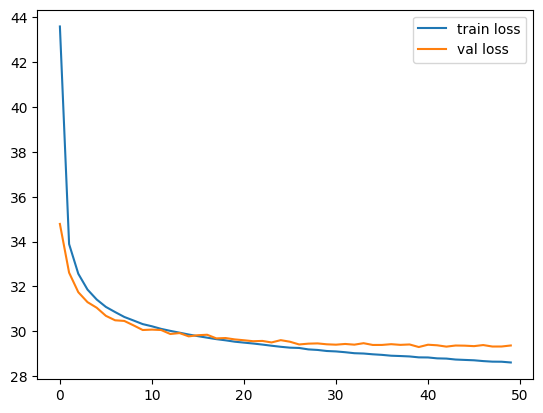

In [15]:
def plot_losses(history):
    losses = history.history
    plt.plot(losses['loss'], label='train loss')
    plt.plot(losses['val_loss'], label='val loss')
    plt.legend()
    plt.show()

plot_losses(history)

## Results

TODO - Reconstruct the test images, plot 10 of them

313/313 [==============================] - 1s 3ms/step


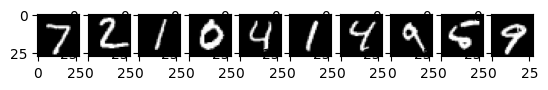

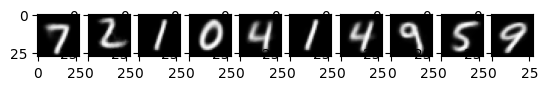

In [17]:
#TODO - Reconstruct the test images
decoded_images = vae.predict([X_test, y_test_one_hot])

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


TODO - Generate 10 new images, one for each class.

1/1 [==============================] - 0s 42ms/step


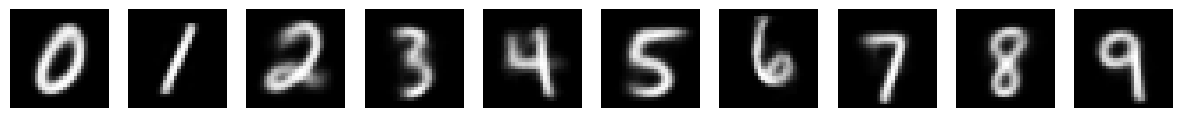

In [18]:
n_images = 10
n_classes = 10
latent_dim = 2  # Adjust this if your VAE uses a different latent dimension

# Sample points in latent space around zero for generating images
z_gen = np.random.normal(size=(n_images, latent_dim))  # Random points for each class
labels_gen = np.identity(n_classes)  # One-hot encoded labels, one for each class

# Concatenate latent variables with labels
z_labels_gen = np.concatenate([z_gen, labels_gen], axis=1)

# Generate new images using the decoder
x_gen = decoder.predict(z_labels_gen)

# Plot the generated images
fig = plt.figure(figsize=(15, 15))
for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    plt.imshow(x_gen[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


TODO - Visualize the latent space

313/313 [==============================] - 1s 2ms/step


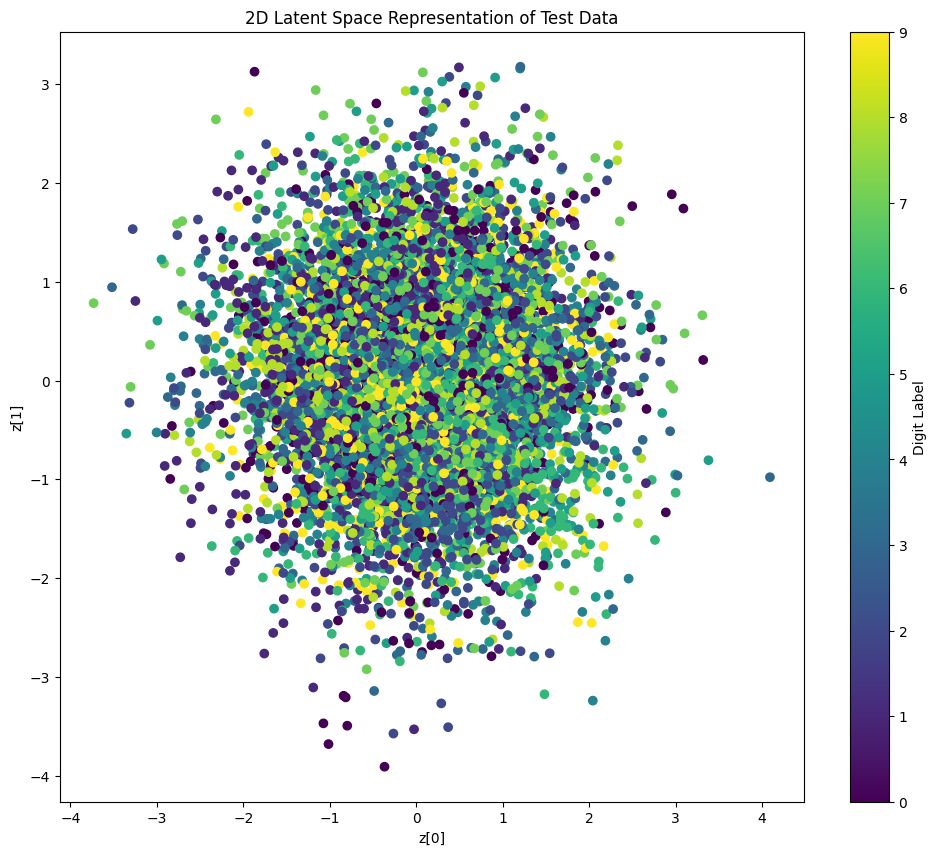

In [19]:
# Get z_mean values for the whole test dataset
z_mean, _, _ = encoder.predict([X_test, y_test_one_hot])

# Plot z_mean in a 2D scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis')
plt.colorbar(label='Digit Label')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("2D Latent Space Representation of Test Data")
plt.show()


TODO - Display a 2D manifold of digit '2' (or any other digit). It will show the variations of the digit throughout the space.

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


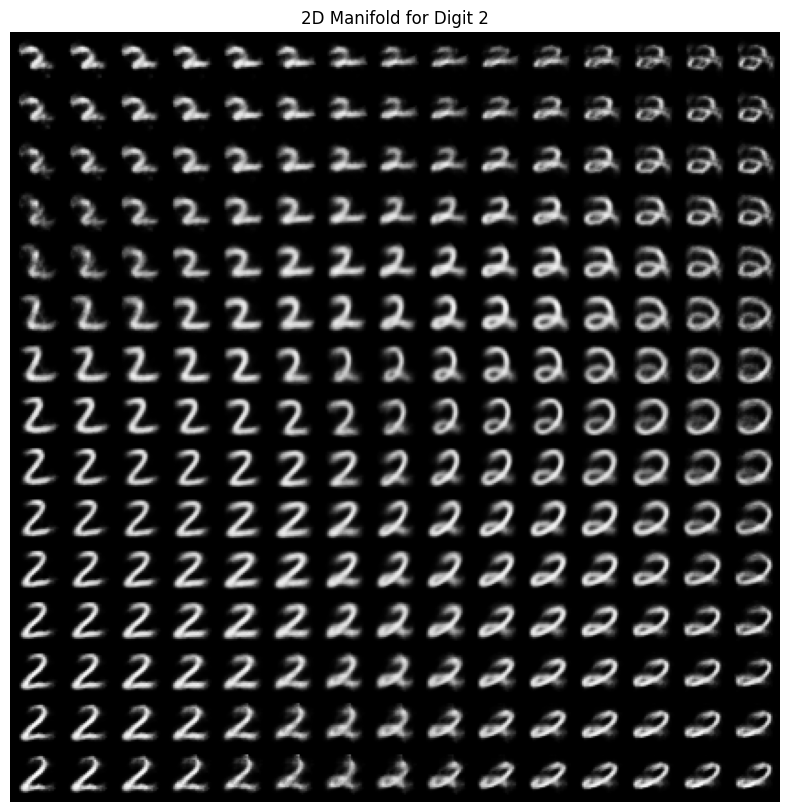

In [21]:
digit_label = 2
digit_label_one_hot = np.zeros((1, n_classes))
digit_label_one_hot[0][digit_label] = 1

n = 15  # figure with 15x15 grid of digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample grid within [-3, 3] standard deviations in latent space
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])  # Latent variable coordinates
        z_sample_with_label = np.concatenate([z_sample, digit_label_one_hot], axis=1)

        # Generate an image with the decoder using the sampled z and fixed label
        x_decoded = decoder.predict(z_sample_with_label)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.title(f"2D Manifold for Digit {digit_label}")
plt.axis('off')
plt.show()
